# **IEOR 4571 Fall 2020 Homework2 Report**


- Hu, Bo (uni: bh2569)
- Qin, Rui (uni: rq217)
- Yuan, Shuibenyang (uni: sy2938)

In [1]:
%load_ext autoreload
%autoreload 2 
import sys
sys.path.append('../')

# Objective

# The Sample

In [2]:
# todo how did we sample the data

In [3]:
from src.utils import loading, Spark
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import numpy as np

## Load Sample

In [4]:
# create spark session
spark = Spark()

Spark UI address http://127.0.0.1:4041


In [5]:
# load sample data from '/data/raw/sample.csv'
datas = loading(spark, '../data/raw')
sample = datas['sample']

## Sample Objectives

In [6]:
print(f'''
            number of data points in the sample: {sample.count()},
            number of unique users in the sample: {sample.select('userId').distinct().count()},
            number of unique movies in the sample: {sample.select('movieId').distinct().count()},
            mean of number of movies a user rated:{sample.groupby('userId').agg(F.count('movieId').alias('cnt')).select(F.mean('cnt')).collect()[0][0]},
            mean of number of users a movie be rated: {sample.groupby('movieId').agg(F.count('userId').alias('cnt')).select(F.mean('cnt')).collect()[0][0]},
            average rating: {sample.select(F.mean('rating')).collect()[0][0]},
            standard deviation of rating: {sample.select(F.stddev('rating')).collect()[0][0]},
            average rating by user: {sample.groupby('userId').agg(F.mean('rating').alias('rating')).select(F.mean('rating')).collect()[0][0]},
            standard deviation of rating by user mean: {sample.groupby('userId').agg(F.mean('rating').alias('rating')).select(F.stddev('rating')).collect()[0][0]},
            average rating by movie: {sample.groupby('movieId').agg(F.mean('rating').alias('rating')).select(F.mean('rating')).collect()[0][0]},
            standard deviation of rating by movie mean: {sample.groupby('movieId').agg(F.mean('rating').alias('rating')).select(F.stddev('rating')).collect()[0][0]}
        ''')


            number of data points in the sample: 444289,
            number of unique users in the sample: 20000,
            number of unique movies in the sample: 1000,
            mean of number of movies a user rated:22.21445,
            mean of number of users a movie be rated: 444.289,
            average rating: 3.562069958968149,
            standard deviation of rating: 1.0467842419621054,
            average rating by user: 3.6858266014487313,
            standard deviation of rating by user mean: 0.5225862364055158,
            average rating by movie: 3.2909220293781765,
            standard deviation of rating by movie mean: 0.5133362661920545
        


# Evaluation

## Cross Validation Setup

In [7]:
from src.evaluation import Evaluator, Cross_validate_als
from src.model_based import Als
import time

In [8]:
splits = loading(spark, '../data/interim')

In [9]:
print(list(splits.keys()))

['train_0.5_0.5', 'train_0.25_0.75', 'test_0.5_0.5', 'test_0.25_0.75', 'train_0.75_0.25', 'test_0.75_0.25']


In [10]:
# build evaluation pipeline
def evaluate(train, test, evaluators, model):
    print('training')
    start = time.time()
    model.fit(train)
    end = time.time()
    print(f'training time: {round(end - start, 2)} seconds')
    print('inferencing train set')
    start = time.time()
    train_pred = model.predict(train)
    end = time.time()
    print(f'inference time: {round(end - start, 2)} seconds')
    print('inferencing test set')
    start = time.time()
    test_pred = model.predict(test)
    end = time.time()
    print(f'inference time: {round(end - start, 2)} seconds')
    res = pd.DataFrame(np.zeros((len(evaluators),2)), columns = ['train', 'test'], index = evaluators.keys())
    for eva in evaluators.keys():
        res.loc[eva, 'train'] = evaluators[eva].evaluate(train_pred)
        res.loc[eva, 'test'] = evaluators[eva].evaluate(test_pred)
    return res

## Metrics

In [11]:
evaluators = {'rmse': Evaluator(metrics = 'rmse'), 
              'accuracy': Evaluator(metrics = 'accuracy'), 
              'coverage_2': Evaluator(metrics = 'converage_k', 
                                       ratingCol='rating', 
                                       predCol='prediction', 
                                       idCol='userId', 
                                       k=2)}

## Baseline Model

In [12]:
from src.baseline import Baseline

In [13]:
model = Baseline()

In [14]:
%%time
result = []
for i in ['0.75_0.25', '0.5_0.5', '0.25_0.75']:
    train, test = splits['train_' + i], splits['test_' + i]
    res = evaluate(train, test, evaluators, model)
    result.append(res)
baseline_res = pd.DataFrame(index=['rmse', 'accuracy', 'coverage_5'], columns = ['train', 'test', 'split'])
for i, j in zip(result, ['0.75_0.25', '0.5_0.5', '0.25_0.75']):
    i['split'] = j
    baseline_res = baseline_res.append(i)
baseline_res = baseline_res.dropna()

training
training time: 0.17 seconds
inferencing train set
inference time: 0.07 seconds
inferencing test set
inference time: 0.05 seconds
training
training time: 0.02 seconds
inferencing train set
inference time: 0.04 seconds
inferencing test set
inference time: 0.03 seconds
training
training time: 0.03 seconds
inferencing train set
inference time: 0.04 seconds
inferencing test set
inference time: 0.05 seconds
CPU times: user 123 ms, sys: 32.4 ms, total: 155 ms
Wall time: 25.3 s


# BO ANALYSIS DEV

In [27]:
import matplotlib.pyplot as plt

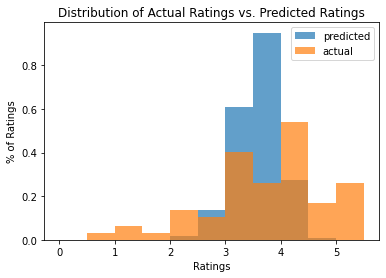

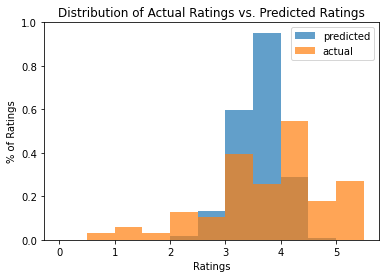

In [67]:
# 1.
def rating_distribution(splits_df,model):
    raw = model.predict(splits_df).toPandas()
    fig, ax = plt.subplots(1,1)
    raw.prediction.plot(kind='hist',bins=np.arange(0,6,0.5),ax=ax,alpha=0.7,density=True,label='predicted')
    raw.rating.plot(kind='hist',bins=np.arange(0,6,0.5),ax=ax,alpha=0.7,density=True,label='actual')
    plt.legend()
    plt.xlabel("Ratings")
    plt.ylabel("% of Ratings")
    plt.title("Distribution of Actual Ratings vs. Predicted Ratings")
    return

rating_distribution(splits['test_0.5_0.5'],model)
rating_distribution(splits['test_0.25_0.75'],model)

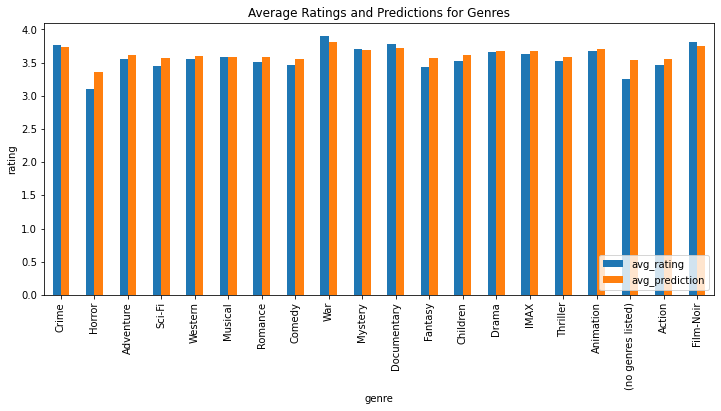

In [95]:
# 2.
movies = spark.read.csv("../data/raw/movies.csv",header=True)

# helper to append genre to rating table
def append_genre(sample):
    copy = movies.withColumn("genre_lst",F.split("genres","\|").alias("genre_lst")) # add a new col of genres.split("|")
    with_genre = copy.join(sample,copy.movieId == sample.movieId).drop(sample.movieId)
    movie_genre = with_genre.select("movieId",F.explode("genre_lst").alias("genre"),"rating","prediction")
    return movie_genre

# func to create the table with genre, mean ratings, and mean pred
def mean_by_genre(splits_df,model):
    with_pred = model.predict(splits_df)
    with_genre = append_genre(with_pred)
    avg = with_genre.groupBy("genre").agg(F.mean("rating").alias("avg_rating"),F.mean("prediction").alias("avg_prediction"))
    return avg

# func to plot 
def draw_mean_genre(avg):
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    avg.toPandas().plot(x='genre',y=['avg_rating','avg_prediction'],kind='bar',ax=ax)
    plt.ylabel("rating")
    plt.legend(loc='lower right')
    plt.title("Average Ratings and Predictions for Genres")
    return

draw_mean_genre(mean_by_genre(splits['test_0.25_0.75'],model))


In [137]:
# 3.
def loss_user(splits_df,model,minloss=True):
    with_pred = model.predict(splits['test_0.25_0.75'])
    with_se = with_pred.withColumn("SE",(with_pred.rating - with_pred.prediction)**2)
    with_mse = with_se.groupBy("userID").agg(F.mean("SE").alias("MSE")).orderBy("MSE",ascending=minloss)
    user = with_mse.take(1)[0][0]
    mse = with_mse.take(1)[0][1]
    print("MSE for this user is: "+str(mse))
    return with_pred[with_pred.userId == user]

In [140]:
loss_user(splits['test_0.25_0.75'],model,False).toPandas()

MSE for this user is: 15.903924768004282


,userId,movieId,rating,prediction
0,51926,750,0.5,4.492484
1,51926,58559,0.5,4.469204
2,51926,6016,0.5,4.505055
3,51926,912,0.5,4.485063


# END

In [31]:
baseline_res.to_csv('../data/processed/baseline_res.csv', header = True, index = True)

In [15]:
baseline_res

,train,test,split
rmse,0.871576,0.913753,0.75_0.25
accuracy,0.859188,0.831457,0.75_0.25
coverage_2,0.991162,0.716097,0.75_0.25
rmse,0.858781,0.922455,0.5_0.5
accuracy,0.865157,0.832447,0.5_0.5
coverage_2,0.979832,0.962492,0.5_0.5
rmse,0.832999,0.937656,0.25_0.75
accuracy,0.874522,0.829091,0.25_0.75
coverage_2,0.911197,0.981760,0.25_0.75


## Memory Based Collaborative Filtering

In [16]:
from src.memory_based import Memory_based_CF

### User Based Collaborative Filtering

In [17]:
cf = Memory_based_CF(spark, 'user')

In [18]:
%%time
result = []
for i in ['0.75_0.25', '0.5_0.5', '0.25_0.75']:
    train, test = splits['train_' + i], splits['test_' + i]
    res = evaluate(train, test, evaluators, cf)
    result.append(res)
ub_CF_res = pd.DataFrame(index=['rmse', 'accuracy', 'coverage_5'], columns = ['train', 'test', 'split'])
for i, j in zip(result, ['0.75_0.25', '0.5_0.5', '0.25_0.75']):
    i['split'] = j
    ub_CF_res = ub_CF_res.append(i)
ub_CF_res = ub_CF_res.dropna()

training
training time: 38.95 seconds
inferencing train set
inference time: 10.73 seconds
inferencing test set
inference time: 3.67 seconds
training
training time: 34.61 seconds
inferencing train set
inference time: 7.39 seconds
inferencing test set
inference time: 7.17 seconds
training
training time: 31.48 seconds
inferencing train set
inference time: 4.45 seconds
inferencing test set
inference time: 10.67 seconds
CPU times: user 3min 52s, sys: 31.8 s, total: 4min 24s
Wall time: 2min 34s


In [19]:
ub_CF_res

,train,test,split
rmse,0.821108,0.894580,0.75_0.25
accuracy,0.842982,0.803747,0.75_0.25
coverage_2,0.983591,0.708690,0.75_0.25
rmse,0.808453,0.921639,0.5_0.5
accuracy,0.851055,0.797801,0.5_0.5
coverage_2,0.969546,0.945709,0.5_0.5
rmse,0.784599,0.980886,0.25_0.75
accuracy,0.861927,0.779768,0.25_0.75
coverage_2,0.910176,0.967936,0.25_0.75


In [20]:
ub_CF_res.to_csv('../data/processed/ub_cf_res.csv', header = True, index = True)

### Item Based Collaborative Filtering

In [21]:
cf = Memory_based_CF(spark, 'item')

In [22]:
%%time
result = []
for i in ['0.75_0.25', '0.5_0.5', '0.25_0.75']:
    train, test = splits['train_' + i], splits['test_' + i]
    res = evaluate(train, test, evaluators, cf)
    result.append(res)
ib_CF_res = pd.DataFrame(index=['rmse', 'accuracy', 'coverage_5'], columns = ['train', 'test', 'split'])
for i, j in zip(result, ['0.75_0.25', '0.5_0.5', '0.25_0.75']):
    i['split'] = j
    ib_CF_res = ib_CF_res.append(i)
ib_CF_res = ib_CF_res.dropna()

training
training time: 6.04 seconds
inferencing train set
inference time: 11.87 seconds
inferencing test set
inference time: 3.95 seconds
training
training time: 5.83 seconds
inferencing train set
inference time: 7.73 seconds
inferencing test set
inference time: 7.5 seconds
training
training time: 4.75 seconds
inferencing train set
inference time: 4.16 seconds
inferencing test set
inference time: 10.59 seconds
CPU times: user 56.4 s, sys: 2.1 s, total: 58.5 s
Wall time: 1min 6s


In [23]:
ib_CF_res

,train,test,split
rmse,0.847614,0.868404,0.75_0.25
accuracy,0.837997,0.811680,0.75_0.25
coverage_2,0.977120,0.705143,0.75_0.25
rmse,0.867596,0.895520,0.5_0.5
accuracy,0.837147,0.807913,0.5_0.5
coverage_2,0.951262,0.932456,0.5_0.5
rmse,0.942725,0.960093,0.25_0.75
accuracy,0.825541,0.793047,0.25_0.75
coverage_2,0.864011,0.958940,0.25_0.75


In [24]:
ib_CF_res.to_csv('../data/processed/ib_cf_res.csv', header = True, index = True)

## Model Based Collaborative Filtering

### ALS Matrix Factorization Approximation

In [25]:
from src.evaluation import Cross_validate_als

#### Parameter Tuning for ALS

In [22]:
parameters = {
    "regParam": [0.01, 0.05, 0.1, 0.15],
    "rank": [10, 50, 100, 150, 200]
}

cf = cf = Als(userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                regParam=.15,
                seed=0,
                rank=10
                )

In [23]:
result = []
for i in ['0.75_0.25', '0.5_0.5', '0.25_0.75']:
    train, test = splits['train_' + i], splits['test_' + i]
    res = Cross_validate_als(training = train,
                            test= test,
                            valid_ratio = .1,
                            regParam = parameters['regParam'],
                            rank = parameters['rank'],
                            seed = 0,
                            evaluators = list(evaluators.values()))
    result.append(res)

100%|██████████| 20/20 [09:07<00:00, 27.37s/it]


In [24]:
als_parameter_tuning = pd.DataFrame(columns = ['rmse', 'accuracy', 'converage_k'])
for i, j in zip(result, ['0.75_0.25', '0.5_0.5', '0.25_0.75']):
    i['split'] = j
    als_parameter_tuning = als_parameter_tuning.append(i)
als_parameter_tuning = als_parameter_tuning.dropna()
als_parameter_tuning.index.name = '(regParam, rank)'
als_parameter_tuning.to_csv('../data/processed/als_parameter_tuning.csv', header=True, index=True)

In [26]:
print(f'the best parameter for each split and metric is')
print(f'best param for accuracy')
display(als_parameter_tuning.groupby('split').rmse.apply(lambda x: x.idxmin()))
print(f'best param for rmse')
display(als_parameter_tuning.groupby('split').accuracy.apply(lambda x: x.idxmax()))
print(f'best param for coverage_k')
display(als_parameter_tuning.groupby('split').accuracy.apply(lambda x: x.idxmax()))

the best parameter for each split and metric is
best param for accuracy


split
0.25_0.75    (0.15, 10)
0.5_0.5      (0.15, 10)
0.75_0.25    (0.15, 10)
Name: rmse, dtype: object

best param for rmse


split
0.25_0.75    (0.15, 10)
0.5_0.5      (0.15, 10)
0.75_0.25    (0.15, 10)
Name: accuracy, dtype: object

best param for coverage_k


split
0.25_0.75    (0.15, 10)
0.5_0.5      (0.15, 10)
0.75_0.25    (0.15, 10)
Name: accuracy, dtype: object

We will choose the best parameter regParam = .15, rank = 10

#### ALS evaluation

In [26]:
from src.model_based import Als

In [27]:
cf = Als(userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                regParam=.15,
                seed=0,
                rank=10
                )

In [28]:
%%time
result = []
for i in ['0.75_0.25', '0.5_0.5', '0.25_0.75']:
    train, test = splits['train_' + i], splits['test_' + i]
    res = evaluate(train, test, evaluators, cf)
    result.append(res)
als_cf_res = pd.DataFrame(index=['rmse', 'accuracy', 'coverage_5'], columns = ['train', 'test', 'split'])
for i, j in zip(result, ['0.75_0.25', '0.5_0.5', '0.25_0.75']):
    i['split'] = j
    als_cf_res = als_cf_res.append(i)
als_cf_res = als_cf_res.dropna()

training
training time: 3.74 seconds
inferencing train set
inference time: 0.02 seconds
inferencing test set
inference time: 0.02 seconds
training
training time: 2.01 seconds
inferencing train set
inference time: 0.02 seconds
inferencing test set
inference time: 0.02 seconds
training
training time: 1.57 seconds
inferencing train set
inference time: 0.02 seconds
inferencing test set
inference time: 0.01 seconds
CPU times: user 97.2 ms, sys: 33.1 ms, total: 130 ms
Wall time: 26.7 s


In [29]:
als_cf_res.to_csv('../data/processed/als_result.csv', header=True, index=True)

In [30]:
als_cf_res

,train,test,split
rmse,0.706560,0.876594,0.75_0.25
accuracy,0.845688,0.768591,0.75_0.25
coverage_2,0.975542,0.692619,0.75_0.25
rmse,0.649651,0.915222,0.5_0.5
accuracy,0.859147,0.751764,0.5_0.5
coverage_2,0.945363,0.903569,0.5_0.5
rmse,0.540238,1.009128,0.25_0.75
accuracy,0.872770,0.705264,0.25_0.75
coverage_2,0.845193,0.923880,0.25_0.75
